# Voor + Achternaam
## Details
> Hier is de vraag of voor bekende mensen de volledige naam  (voor-en achternaam) in de titel beter werkt dan enkel hun achternaam.
## Example
> Beluister hier de eerste audiocolumn van Nico Dijkshoorn: “Mis ik Nederland? Geen moment” Vs. Dijkshoorn scherp voor eigen natie in nieuwe WK-audiocolumn: "Of ik Oranje mis? Geen moment"

## Data

In [1]:
from util import get_cls_train_test

train_x, train_y, test_x, test_y = get_cls_train_test("Voor+Achternaam")
train_y.value_counts()

0    610
1     71
Name: Voor+Achternaam, dtype: int64

## Approach 1: Tf-idf
This might have the same problem as with proper nouns, that we're overfitting on the names currently in the news and not the ones that will be in the future in the news.

f-score: 0.1904761904761905
Confusion matrix: (TP: 209, FP: 0, FN: 17, TN: 2)
Accuracy=92.54% (211/228)


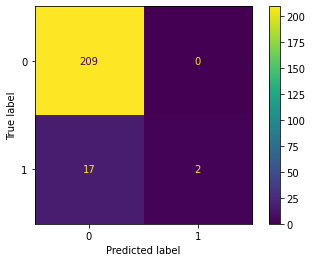

In [2]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

from util import fit_predict_evaluate

model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

In [3]:
from util import show_most_informative_features
show_most_informative_features(model)

1.6999           marc    -0.6821             in
1.5364         markle    -0.6739          trump
1.5149           bart    -0.5999             ik
1.2065         herman    -0.5704            met
1.1986     kardashian    -0.5703            dit
1.1433         gedrag    -0.5427          queen
1.1392        dexters    -0.5408         moeder
1.1392          tanja    -0.5160           voor
1.1223            kim    -0.5048             en
1.0778           demi    -0.4909            hij


As expected, it focuses mainly on currently popular names. Since this only looks word per word, Harry is appearantly used less without a last name. Let's solve the second part using 2-grams or 3-grams:

f-score: 0.09523809523809525
Confusion matrix: (TP: 208, FP: 1, FN: 18, TN: 1)
Accuracy=91.67% (209/228)


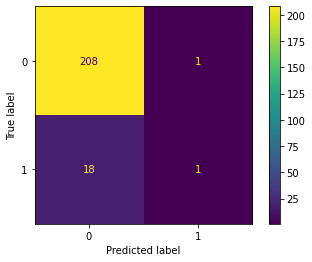

In [4]:
model = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(2,3))),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

The f-score has become a lot lower (since there are almost no positive testing samples), while the accuracy is almost the same.

In [5]:
show_most_informative_features(model)

1.0678  meghan markle    -0.3691          in de
0.9814 kim kardashian    -0.3314          op de
0.9131        bart de    -0.2376        voor de
0.8684  tanja dexters    -0.2351         uit de
0.8508    demi lovato    -0.2218         dit is
0.7022    marc coucke    -0.1982       harry en
0.7011grensoverschrijdend gedrag    -0.1965         in het
0.6959     terug naar    -0.1929   rode duivels
0.6523       te groot    -0.1821  in vlaanderen
0.6408     anne frank    -0.1790harry en meghan


Those 2-grams seem to make more sense than the 1-grams from earlier however.

## Approach 2: SpaCy
SpaCy was excellent in detecting proper nouns. We might be able to check for two consequtive proper nouns.

In [6]:
import spacy
from pprint import pprint

nlp = spacy.load('nl_core_news_sm')
pprint([(x.text, x.pos_, x.dep_, [(x.text, x.dep_) for x in list(x.children)]) for x in nlp(u"Zanger Arno Hintjes overleden")])

[('Zanger', 'NOUN', 'ROOT', []),
 ('Arno', 'PROPN', 'amod', []),
 ('Hintjes', 'NOUN', 'obj', [('Arno', 'amod')]),
 ('overleden', 'VERB', 'ROOT', [('Hintjes', 'obj')])]


Quite strange "Hintjes" is not a proper noun.

In [7]:
pprint([(x.text, x.pos_, x.text) for x in nlp(u"Meghan Markles papa in tranen toen prins Charles zijn dochter weggaf: \"Ik wenste dat ik daar was\"")])

[('Meghan', 'PROPN', 'Meghan'),
 ('Markles', 'PROPN', 'Markles'),
 ('papa', 'VERB', 'papa'),
 ('in', 'ADP', 'in'),
 ('tranen', 'NOUN', 'tranen'),
 ('toen', 'SCONJ', 'toen'),
 ('prins', 'NOUN', 'prins'),
 ('Charles', 'PROPN', 'Charles'),
 ('zijn', 'PRON', 'zijn'),
 ('dochter', 'NOUN', 'dochter'),
 ('weggaf', 'VERB', 'weggaf'),
 (':', 'PUNCT', ':'),
 ('"', 'PUNCT', '"'),
 ('Ik', 'PRON', 'Ik'),
 ('wenste', 'VERB', 'wenste'),
 ('dat', 'SCONJ', 'dat'),
 ('ik', 'PRON', 'ik'),
 ('daar', 'ADV', 'daar'),
 ('was', 'VERB', 'was'),
 ('"', 'PUNCT', '"')]


In [8]:
def contains_consecutive_pronouns(headline):
    previous_propn = False
    for x in nlp(headline):
        if x.pos_ == 'PROPN' and previous_propn:
            return True
        previous_propn = x.pos_ == 'PROPN'
    return False

print(contains_consecutive_pronouns(u"Meghan Markles papa in tranen toen prins Charles zijn dochter weggaf"))
print(contains_consecutive_pronouns(u"Meghans papa in tranen toen prins Charles zijn dochter weggaf"))

True
False


f-score: 0.5245901639344263
Confusion matrix: (TP: 183, FP: 26, FN: 3, TN: 16)
Accuracy=87.28% (199/228)


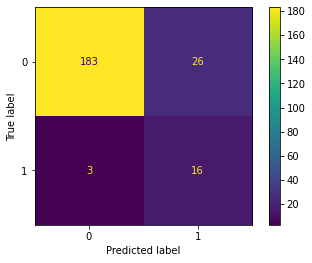

In [9]:
import numpy as np
from util import print_evaluation

prediction = np.vectorize(contains_consecutive_pronouns)(test_x)
print_evaluation(test_y, prediction)

 A slightly worse accuracy, but the f-score is already better.

In [10]:
# False positives
prediction = train_x.apply(contains_consecutive_pronouns)
train_x[(prediction != train_y) & (prediction == 1)][:5]

Test      
102   270     Hij is de beroemdste peuter van België, maar w...
733   1834    "Zo ga ik beroemd worden": cliniclown Kevin (3...
3     4       Maandag drukste dag van het jaar op Brussels A...
465   1172    Club Brugge haalt Nederlands talent met straff...
495   1237    Man zwemt in zes maanden en in 9.000 kilometer...
Name: Headline, dtype: object

Things like "Manneke Pis", "Club Brugge", "Stille Ocean" are false positives. Let's see if we can solve this by combining this function with Tf-Idf.

## Approach 3: Tf-Idf + Consecutive proper nouns (SpaCy)

f-score: 0.6666666666666666
Confusion matrix: (TP: 200, FP: 9, FN: 5, TN: 14)
Accuracy=93.86% (214/228)


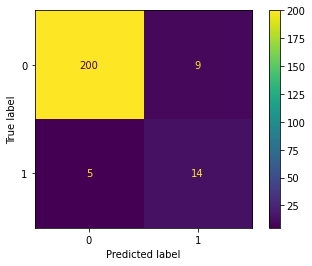

In [11]:
from sklearn.pipeline import FeatureUnion
from util import FunctionTransformer
model = Pipeline([
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
        ('consecutive_pronouns', FunctionTransformer(contains_consecutive_pronouns))
    ])),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

We're getting a better accuracy and a better f-score now.

In [12]:
show_most_informative_features(model, vectorizer=model.named_steps['union'].transformer_list[0][1])

1.3005         zitten    -1.1260           rode
1.0842           demi    -0.7400        duivels
1.0842         lovato    -0.7092            uit
1.0787         hilton    -0.6527           club
1.0787          paris    -0.6261           maar
0.8728           niet    -0.6123           voor
0.8459    belangrijke    -0.6060             op
0.8459     executeren    -0.5970             ik
0.8325            mol    -0.5704     temptation
0.8307           marc    -0.5687          trump


Some words related to "Rode Duivels" (rode, duivels, doelman ...). Let's try 2-grams again:

f-score: 0.5714285714285714
Confusion matrix: (TP: 193, FP: 16, FN: 5, TN: 14)
Accuracy=90.79% (207/228)


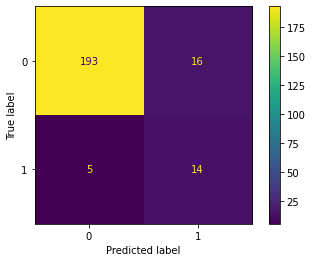

In [14]:
model = Pipeline([
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer(ngram_range=(2, 2))),
        ('consecutive_pronouns', FunctionTransformer(contains_consecutive_pronouns))
    ])),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

In [15]:
show_most_informative_features(model, vectorizer=model.named_steps['union'].transformer_list[0][1])

1.0833    demi lovato    -0.8996   rode duivels
0.9351   paris hilton    -0.6517        de rode
0.7770      erpe mere    -0.4987          is de
0.7770honderden treinreizigers    -0.4861    club brugge
0.7770        in erpe    -0.4731          op de
0.7770treinreizigers zitten    -0.4036         uit de
0.7770    zitten vast    -0.3973temptation island
0.7569     terug naar    -0.3883        met een
0.6765    in kritieke    -0.3805   test aankoop
0.6765kritieke toestand    -0.3659          in de


Still stragne results, I would've expected way more firt+lastname pairs with a positive impact. I did expect words like "rode duivels", "club brugge", "temptation island" and "test aankoop" with a negative impact, as it's now the case.